In [1]:
import numpy as np
import torch
from pathlib import Path
from pyro.distributions import Normal
import os
from bnn_priors.models import DenseNet
from bnn_priors.inference import SGLD
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load("../data/snelson.npz")

model = DenseNet(1,1,32)
if torch.cuda.is_available():
    model = model.cuda()

x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(model.lin1.weight)
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

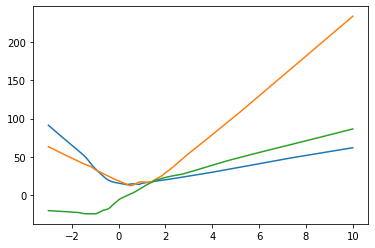

In [3]:
with torch.no_grad():
    for _ in range(3):
        model.sample_all_priors()
        y = model(x_test).loc.cpu()
        plt.plot(x_test.cpu(), y)

In [4]:
N_steps = 1000 # 100
warmup = 2000 # 50

model = DenseNet(1,1,32)
if torch.cuda.is_available():
    model = model.cuda()   # Resample model with He initialization so SGLD works.

sgld = SGLD(model=model, num_samples=N_steps, warmup_steps=warmup, learning_rate=1e-4)
sgld.run(x=x_train, y=y_train)

samples = sgld.get_samples()

It. 0, loss=1355.0168
It. 100, loss=1313.6692
It. 200, loss=1308.8148
It. 300, loss=1305.1798
It. 400, loss=1300.5505
It. 500, loss=1296.4547
It. 600, loss=1292.4969
It. 700, loss=1288.9354
It. 800, loss=1285.9011
It. 900, loss=1283.5018
It. 1000, loss=1281.7313
It. 1100, loss=1280.5010
It. 1200, loss=1279.6672
It. 1300, loss=1279.0812
It. 1400, loss=1278.6191
It. 1500, loss=1278.2396
It. 1600, loss=1277.9285
It. 1700, loss=1277.6674
It. 1800, loss=1277.4368
It. 1900, loss=1277.2275
It. 0, loss=1277.0376
It. 100, loss=1276.8521
It. 200, loss=1276.6776
It. 300, loss=1276.5116
It. 400, loss=1276.3502
It. 500, loss=1276.1926
It. 600, loss=1276.0374
It. 700, loss=1275.8855
It. 800, loss=1275.7383
It. 900, loss=1275.5947


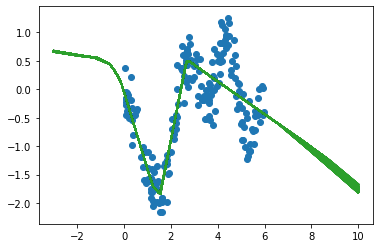

In [5]:
for i in range(N_steps):
    param_sample = {param : value[i] for param, value in samples.items()}
    model.load_state_dict(param_sample)
    with torch.no_grad():
        plt.plot(x_test.cpu(), model(x_test).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()